In [2]:
import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri(uri="http://127.0.0.1:7777")
mlflow.set_experiment("LSTM Experiments")

<Experiment: artifact_location='mlflow-artifacts:/993622068413647721', creation_time=1730058768079, experiment_id='993622068413647721', last_update_time=1730058768079, lifecycle_stage='active', name='LSTM Experiments', tags={}>


############################################################################
##################  SOME GENERAL PLOT  CONFIGURATIONS  #####################
############################################################################

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm

# %matplotlib inline

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()

############################################################################
###############  YFINANCE - DOWNLOAD DATA AND CREATE DF  ###################
############################################################################


In [3]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np

stock_end_date = date.today().strftime("%Y-%m-%d") # GRUPO : DECIDIR
stock_start_date = '2020-01-01'                    # GRUPO : DECIDIR
ticket = 'PETR4.SA'
n_tickers = 1
df = yf.download(ticket, start=stock_start_date, end=stock_end_date)

# Inspect the data
print(df.head())
print(df.info())


[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                      PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA   
Date                                                                    
2020-01-02 00:00:00+00:00  10.621439  30.700001  30.700001  30.309999   
2020-01-03 00:00:00+00:00  10.534945  30.450001  31.240000  30.450001   
2020-01-06 00:00:00+00:00  10.659495  30.809999  30.940001  29.950001   
2020-01-07 00:00:00+00:00  10.617978  30.690001  30.879999  30.469999   
2020-01-08 00:00:00+00:00  10.552243  30.500000  30.770000  30.240000   

Price                           Open    Volume  
Ticker                      PETR4.SA  PETR4.SA  
Date                                            
2020-01-02 00:00:00+00:00  30.510000  37774500  
2020-01-03 00:00:00+00:00  30.879999  71595600  
2020-01-06 00:00:00+00:00  30.430000  81844000  
2020-01-07 00:00:00+00:00  30.820000  32822000  
2020-01-08 00:00:00+00:00  30.690001  48215600  
<class 'pandas.core.fra

############################################################################
############  FUNCTION TO PLOT YFINANCE DATA THROUGH DATES  ################
############################################################################


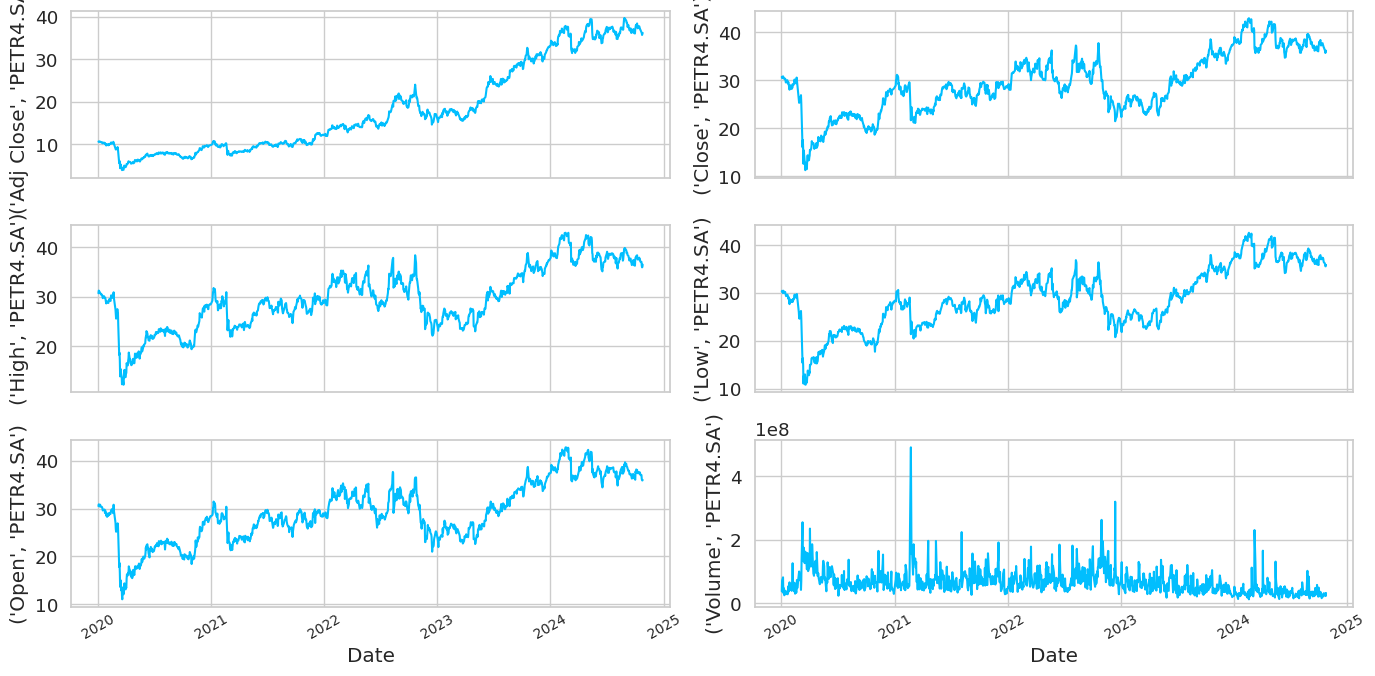

In [4]:
import matplotlib.dates as mdates

def data_plot(df):
    # Plot line charts
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

# Plot the data
data_plot(df)

############################################################################
##############  SPLIT TRAIN AND TEST DATA + RESHAPE DATA  ##################
############################################################################


In [4]:
import math

# Train test split
training_data_len = math.ceil(len(df) * .8)     # GRUPO : DECIDIR
print(training_data_len)

# Splitting the dataset
train_data = df[:training_data_len].iloc[:, :1]
test_data = df[training_data_len:].iloc[:, :1]
print(train_data.shape, test_data.shape)

# Selecting Open Price values
dataset_train = train_data["Adj Close"].values  # GRUPO : CLOSE
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

# Selecting Open Price values
dataset_test = test_data["Adj Close"].values    # GRUPO : CLOSE
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)


962
(962, 1) (240, 1)
(962, 1)
(240, 1)


############################################################################
####################  SCALING DATA WITH MINMAXSCALER  ######################
############################################################################


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1),clip=True)     # GRUPO : DECIDIR
# Scaling dataset - FIT SÓ AQUI
scaled_train = scaler.fit_transform(dataset_train)
np.nan_to_num(scaled_train,copy=False,nan=0.0)
print(scaled_train[:5])

# Normalizing values between 0 and 1 - AQUI SÓ TRANSFORM
scaled_test = scaler.transform(dataset_test)
np.nan_to_num(scaled_test,copy=False,nan=0.0)
print(scaled_test[:5])


[[0.23360092]
 [0.23059216]
 [0.23492475]
 [0.23348053]
 [0.23119388]]
[[0.93099815]
 [0.91242064]
 [0.94662665]
 [0.94751141]
 [0.9363058 ]]


############################################################################
##############  SPLIT DATA INTO X (INPUTS) AND Y (LABLES)  #################
############################################################################

In [6]:
# COLOCAR ESSE STEP NA PIPELINE DE DADOS

def create_dataset_from_moving_window(scaled_data, window_length, n_features):
    
    # Create sequences and labels for training data
    L_dataset = len(scaled_data)
    X, y = [], []
    for i in range(L_dataset - window_length):
        X.append(scaled_data[i:i + window_length,0:n_features])
        y.append(scaled_data[i + window_length,n_features-1:])  # Predicting the value right after the sequence
    X, y = np.array(X), np.array(y)
    return X, y

W_train = 50
W_test = 50
X_train, y_train = create_dataset_from_moving_window(scaled_train, window_length=W_train, n_features=n_tickers)
X_test, y_test = create_dataset_from_moving_window(scaled_test, window_length=W_test, n_features=n_tickers)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(912, 50, 1) (912, 1)
(190, 50, 1) (190, 1)


############################################################################
################  CONVERT DATA TO PYTORCH TENSOR  ##########################
############################################################################


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([912, 50, 1]) torch.Size([912, 1])
torch.Size([190, 50, 1]) torch.Size([190, 1])


############################################################################
##############  CREATING LSTM CUSTOM CLASS WITH LINEAR OUT  ################
############################################################################


In [15]:
class LSTMModel(nn.Module):
    # AVALIAR INICIALIZAÇÃO DOS PESOS
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out


############################################################################
######################  SETUP / CONFIGS FOR TRAINING  ######################
############################################################################

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = n_tickers          # GRUPO : HYPERPARAMETROS
num_layers = 10         # GRUPO : HYPERPARAMETROS
hidden_size = 100       # GRUPO : HYPERPARAMETROS
output_size = 1
dropout = 0.2           # Regulatization // GRUPO : HYPERPARAMETROS
learning_rate = 0.001  # GRUPO : HYPERPARAMETROS

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')  # GRUPO : DECIDIR
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # GRUPO : DECIDIR

batch_size = 30  # GRUPO : VERIFICAR
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 10  # GRUPO : HYPERPARAMETROS
train_hist = []
test_hist = []


cpu


############################################################################
###################  LSTM TRAINING // LSTM TRANING  ########################
############################################################################


In [21]:
params_to_log = {
    "start_date" : stock_start_date,
    "end_date" : stock_end_date,
    "batch_size" : batch_size,
    "sequence_length_train" : W_train,
    "sequence_length_test" : W_test,
    "input_size" : input_size,
    "num_layers" : num_layers,
    "hidden_size" : hidden_size,
    "dropout" : dropout,
    "learning_rate" : learning_rate,
    "num_epochs" : num_epochs,
    "optimizer" : optimizer,
    "loss_fn" : loss_fn,
}


import time

start_training_time = time.time()
print(f"Starting training: {start_training_time}")
#mlflow.pytorch.autolog()
with mlflow.start_run():

    mlflow.set_tag("Fase","1 - Define Baseline")
    mlflow.log_params(params_to_log)

    for epoch in range(num_epochs):
        total_loss = 0.0
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)

        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0

            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)

                total_test_loss += test_loss.item()

            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

    end_training_time = time.time()
    elapsed_training_time = end_training_time - start_training_time
    print(f"Ending training: {end_training_time}")
    print(f"Elapsed Training time: {elapsed_training_time}")
    
    mlflow.log_metric('training_time', elapsed_training_time)
    mlflow.log_metric('training_loss', average_loss)
    mlflow.log_metric('test_loss', average_test_loss)
    mlflow.pytorch.log_model(model, "model")
    

    ############################################################################
    #########################  PLOT TRAINING RESULTS  ##########################
    ############################################################################

    """
    x = np.linspace(1,num_epochs,num_epochs)
    plt.plot(x,train_hist,scalex=True, label="Training loss")
    plt.plot(x, test_hist, label="Test loss")
    plt.legend()
    plt.show(block=False)"""

    ############################################################################
    #################### PREDICT // FORECAST RESULTS  ##########################
    ############################################################################

    num_forecast_steps = 30
    sequence_to_plot = X_test.squeeze().cpu().numpy()
    print(sequence_to_plot.shape)
    historical_data = sequence_to_plot[-1]
    print(historical_data.shape)

    forecasted_values = []
    with torch.no_grad():
        for _ in range(num_forecast_steps):
            historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, n_tickers).float().to(device)
            # print(historical_data_tensor.shape)
            predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
            # print(predicted_value.shape)
            forecasted_values.append(predicted_value)
            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value

    last_date = test_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

    ############################################################################
    ####################### PLOT PREDICT // FORECAST ###########################
    ############################################################################

    """     
    from pylab import rcParams

    plt.rcParams['figure.figsize'] = [14, 4]
    plt.plot(test_data.index[-100:], test_data[-100:], label="test_data", color="b")
    plt.plot(test_data.index[-30:], test_data[-30:], label='actual values', color='green')
    plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), label='forecasted values', color='red')

    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(True)
    plt.show(block=False) """

    ############################################################################
    #######################   PERFORMANCE METRICS   ###########################
    ############################################################################

    from sklearn.metrics import root_mean_squared_error, r2_score

    # Evaluate the model and calculate RMSE and R² score
    model.eval()
    with torch.no_grad():
        test_predictions = []
        for batch_X_test in X_test:
            batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
            test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

    test_predictions = np.array(test_predictions)

    # Calculate RMSE and R² score
    rmse = root_mean_squared_error(y_test.cpu().numpy(), test_predictions)
    r2 = r2_score(y_test.cpu().numpy(), test_predictions)

    print(f'RMSE: {rmse:.4f}')
    print(f'R² Score: {r2:.4f}')

    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2-Score", r2)

    mlflow.end_run()


Starting training: 1730063092.667097
Epoch [10/10] - Training Loss: 0.0615, Test Loss: 0.4025
Ending training: 1730063178.1709397
Elapsed Training time: 85.50384259223938


2024/10/27 18:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


(190, 50)
(50,)


2024/10/27 18:06:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-hen-547 at: http://127.0.0.1:7777/#/experiments/993622068413647721/runs/9c43603019b94cd788e500a0fac2b4c1.
2024/10/27 18:06:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:7777/#/experiments/993622068413647721.


RMSE: 0.6343
R² Score: -8978.8496


In [7]:
import mlflow
logged_model = 'runs:/9c43603019b94cd788e500a0fac2b4c1/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_test))

/home/raiane/Documentos/Projetos/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Must pass 2-d input. shape=(190, 50, 1)